<a href="https://colab.research.google.com/github/AndrewRomitti/HippocampusSegmentation/blob/main/Notebook1_(2D_Only).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hippocampus Segmentation with 2D MRI Images

In [ ]:
print("Starting Notebook")

Starting Notebook


In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from google.colab import files
input_file = files.upload()

Saving kaggle (7).json to kaggle (7).json


In [ ]:
!pip install -q kaggle > /dev/null 2>&1

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sabermalek/mrihs

 98% 156M/159M [00:05<00:00, 35.1MB/s]
100% 159M/159M [00:05<00:00, 32.2MB/s]


In [ ]:
!unzip /content/mrihs.zip > /dev/null 2>$1

In [ ]:
import numpy as np
import pandas as pd
import tqdm
from PIL import Image
import tqdm
import os
import numpy as np
import cv2
import tensorflow as tf

In [ ]:
!pip install -U -q segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
TRAIN_REAL_PATH = r"/content/original/100"
TRAIN_MASK_PATH = r"/content/label/100label"

TEST_REAL_PATH = r"/content/original/35"
TEST_MASK_PATH = r"/content/label/35label"

In [ ]:
def create_datasets(REAL_PATH, MASK_PATH):

    ######################## MASK DATASET GENERATION ######################################

    PATH_ARRAY_L = []
    PATH_ARRAY_R = []

    for sub_dir in tqdm.tqdm(sorted(os.listdir(MASK_PATH))):
        if sub_dir == "ADNI_013_S_0325_85153_ACPC": #Dataset missing right hippocampus entry so being skipped
            continue
        else:
            for idx, side_sub_dir in enumerate(sorted(os.listdir(MASK_PATH+"/"+sub_dir+"/"))):
                for file in sorted(os.listdir(MASK_PATH+"/"+sub_dir+"/"+side_sub_dir+"/")):
                    if idx==0:
                        PATH_ARRAY_L.append(MASK_PATH+"/"+sub_dir+"/"+side_sub_dir+"/"+file)
                    elif idx==1:
                        PATH_ARRAY_R.append(MASK_PATH+"/"+sub_dir+"/"+side_sub_dir+"/"+file)

    COMBINED_IMG_MASKS = []

    for idx in tqdm.tqdm(range(len(PATH_ARRAY_L))):
        im1 = Image.open(PATH_ARRAY_L[idx])
        im2 = Image.open(PATH_ARRAY_R[idx])
        im3 = np.array(Image.blend(im1, im2, 0.5))
        COMBINED_IMG_MASKS.append(cv2.resize(cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY), (256,256)))

    ########################## TRAIN DATASET GENERATION #######################################

    REAL_IMAGES = []

    for sub_dir in tqdm.tqdm(sorted(os.listdir(REAL_PATH))):
        if sub_dir == "ADNI_013_S_0325_85153_ACPC": #Dataset missing right hippocampus entry so being skipped
            continue
        else:
            for file in sorted(os.listdir(REAL_PATH+"/"+sub_dir+"/")):
                REAL_IMAGES.append(REAL_PATH+"/"+sub_dir+"/"+file)

    REAL_IMAGES_CONVERTED = []

    for idx in tqdm.tqdm(range(len(REAL_IMAGES))):
        im1 = np.array(Image.open(REAL_IMAGES[idx]))
        REAL_IMAGES_CONVERTED.append(cv2.resize(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB), (256,256)))

    return np.array(REAL_IMAGES_CONVERTED), np.expand_dims(np.array(COMBINED_IMG_MASKS),axis=3)

In [ ]:
X_train, y_train = create_datasets(TRAIN_REAL_PATH, TRAIN_MASK_PATH)

100%|██████████| 18711/18711 [00:16<00:00, 1106.91it/s]


In [ ]:
X_test, y_test = create_datasets(TEST_REAL_PATH, TEST_MASK_PATH)

100%|██████████| 6615/6615 [00:05<00:00, 1161.95it/s]


In [ ]:
y_train.shape

(18711, 256, 256, 1)

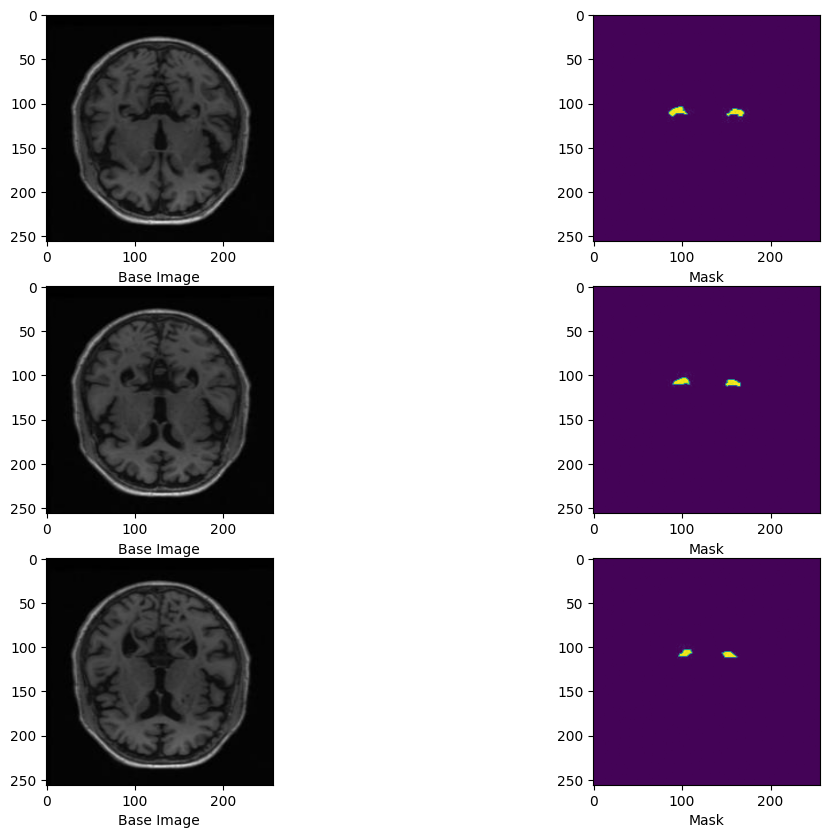

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)

    plt.imshow(X_test[i+65])
    plt.xlabel("Base Image")

    plt.subplot(3,3,i+2)
    plt.imshow(y_test[i+65])
    plt.xlabel("Mask")

In [ ]:
#from sklearn.model_selection import train_test_split

#x_train, x_test, y_train_new, y_test_new = train_test_split(X_train,y_train, test_size=0.4, random_state = 36)

In [ ]:
BATCH_SIZE = 8
DS_SIZE=18711

dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
dataset_test = dataset_test.batch(BATCH_SIZE)

dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_train = dataset_train.batch(BATCH_SIZE)
dataset_train = dataset_train.repeat(3)
dataset_train = dataset_train.shuffle(buffer_size=18711*10)

dataset_test = dataset_test.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, tf.where(tf.cast(y, tf.float32)/255. > 0.1, 1.0, 0.0))) #normalization
dataset_train = dataset_train.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, tf.where(tf.cast(y, tf.float32)/255. > 0.1, 1.0, 0.0))) #normalization

In [ ]:
model = sm.Unet('vgg19', input_shape=(256,256,3), encoder_weights=None, decoder_block_type='transpose')

#model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

loss = sm.losses.DiceLoss()
metric = sm.metrics.FScore()
model.compile('Adam', loss=loss, metrics=[metric])

model.fit(
    dataset_train,
    epochs=150,
    validation_data=(dataset_test),
)

Epoch 1/150
7017/7017 [==============================] - 618s 85ms/step - loss: 0.9821 - f1-score: 0.0179 - val_loss: 0.9869 - val_f1-score: 0.0131
Epoch 2/150
7017/7017 [==============================] - 596s 84ms/step - loss: 0.6635 - f1-score: 0.3365 - val_loss: 0.1983 - val_f1-score: 0.8017
Epoch 3/150
7017/7017 [==============================] - 593s 84ms/step - loss: 0.1954 - f1-score: 0.8046 - val_loss: 0.1983 - val_f1-score: 0.8017
Epoch 4/150
7017/7017 [==============================] - 593s 84ms/step - loss: 0.1954 - f1-score: 0.8046 - val_loss: 0.1983 - val_f1-score: 0.8017
Epoch 5/150
7017/7017 [==============================] - 594s 84ms/step - loss: 0.1954 - f1-score: 0.8046 - val_loss: 0.1983 - val_f1-score: 0.8017
Epoch 6/150
7017/7017 [==============================] - 591s 84ms/step - loss: 0.1954 - f1-score: 0.8046 - val_loss: 0.1983 - val_f1-score: 0.8017
Epoch 7/150
7017/7017 [==============================] - 591s 84ms/step - loss: 0.1954 - f1-score: 0.8046 - val_

In [ ]:
preds = model.predict(dataset_test)

In [ ]:
plt.imshow(y_test[74])

In [ ]:
plt.imshow(preds[74])

In [ ]:
plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)

    plt.imshow(X_test[i])
    plt.xlabel("Base Image")


    plt.subplot(3,3,i+2)
    plt.imshow(y_test[i])
    plt.xlabel("Mask")

    plt.subplot(3,3,i+3)
    plt.imshow(preds[i])
    plt.xlabel("Prediction")